   ## Introduction 
   
   Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home) compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), Irvine's website. 



Here are the descriptions for the relevant columns:

* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. we'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

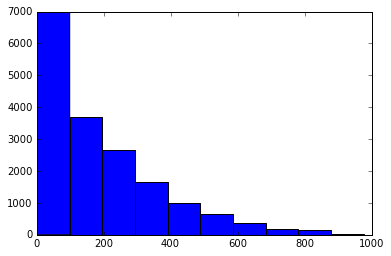

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(bike_rentals["cnt"])

In [3]:
bike_rentals.shape

(17379, 17)

According to the graph above, the cnt column is skewed to the right. About 40% of rentals numbers are less than a 100. 

**let's find out the columns which have a correlation higher than 0.3 with cnt column.**

In [4]:
 #correlation between the df cols and the target 
corrmat= bike_rentals.corr()
print(corrmat)

             instant    season        yr      mnth        hr   holiday  \
instant     1.000000  0.404046  0.866014  0.489164 -0.004775  0.014723   
season      0.404046  1.000000 -0.010742  0.830386 -0.006117 -0.009585   
yr          0.866014 -0.010742  1.000000 -0.010473 -0.003867  0.006692   
mnth        0.489164  0.830386 -0.010473  1.000000 -0.005772  0.018430   
hr         -0.004775 -0.006117 -0.003867 -0.005772  1.000000  0.000479   
holiday     0.014723 -0.009585  0.006692  0.018430  0.000479  1.000000   
weekday     0.001357 -0.002335 -0.004485  0.010400 -0.003498 -0.102088   
workingday -0.003416  0.013743 -0.002196 -0.003477  0.002285 -0.252471   
weathersit -0.014198 -0.014524 -0.019157  0.005400 -0.020203 -0.017036   
temp        0.136178  0.312025  0.040913  0.201691  0.137603 -0.027340   
atemp       0.137615  0.319380  0.039222  0.208096  0.133750 -0.030973   
hum         0.009577  0.150625 -0.083546  0.164411 -0.276498 -0.010588   
windspeed  -0.074505 -0.149773 -0.0087

There are 3 columns that are not correlated with cnt cols. These are candidates of deletion. 

## Time_label feature

The hr column contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently without understanding that certain hours are related.  We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.
I am going to add time_label column to the data set that contains some numbers representing morning, afternoon, evening, and night.

* 1 if the hour is from 6 to 12
* 2 if the hour is from 12 to 18
* 3 if the hour is from 18 to 24
* 4 if the hour is from 0 to 6

In [5]:
def assign_label(hour): 
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"]= bike_rentals["hr"].apply(assign_label)

## Train and Test data sets

At this stage, we're goingt to select 80% of the rows in bike_rentals to be part of the training set and the rest of the rows to the testing set.

In [6]:
#splitting data into train and test sets 
import numpy as np 
import math
np.random.seed(1)
bike_rentals= bike_rentals.reindex(np.random.permutation(bike_rentals.index))

train_max_row= math.floor(bike_rentals.shape[0]* .8)
train= bike_rentals.iloc[: train_max_row]
test= bike_rentals.iloc[train_max_row :]

In [7]:
print(train.shape[0])
print(test.shape[0])

13903
3476


Since cnt column contains continuous values, I am going to use **regression** for modeling. We're starting off with **Linear Regression**, then we'll be attentpting to use Decision Tree Regression, and Random Forest to see which one can give us a better and tight result.

Below are also the metrics i'll be mostly using to assess the performance of the models: 

* **Root of the mean square (RMSE)**: It gives us an absolute number on how much our predicted results deviate from the actual number. I am going to apply each model to both the training data set and the test data set and calculate RMSE for both (called training error and validation error).
* **R Square (R2)**: it indicates how much of the variance the model accounts for. it is a good measure to determine how well the model fits the dependent variables. It is a value between 0 and 1 and a higher value is better. Too high value is too good to be acceptable and can be a sign of overfitting.
* **difference between training error and validation error**: To prevent overfitting I am going to minimize the difference between these two errors while minimizing the errors and looking for high enough R Square.

## Feature Selection 

First of, Let's create a list of predictor columns to use in training and predictions. Let's have a look at the heat map that shows the correlations graphically.

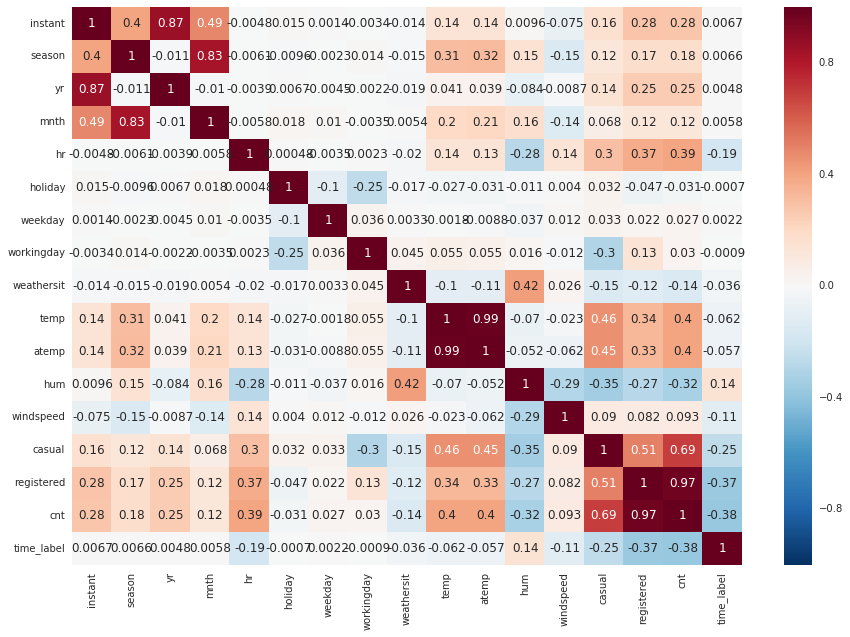

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.heatmap(bike_rentals.corr(), annot=True)

From the heatmap above, here's how we're constructing our features' list: 

* We'll set aside **casual** and **registered** columns because cnt is derived from these two cols.
* **dteday** is also excluded since it is not numeric and its data is mentioned in other columns.
* We're also dropping ** holiday** and **weathersit** since they're not even correlated with cnt and thus can't have an explanatory relation with our target column.
* **instant** will also be removed since it is only an id.
* And, of course ... We'll remove **cnt** since it is the target column.

In [9]:
predictors = train.drop(["cnt", "casual", "dteday", "registered", "holiday", "weathersit", "hum"], axis=1)
features = list(train.columns)
features.remove("cnt")
features.remove("casual")
features.remove("registered")
features.remove("dteday")
features.remove("holiday")
features.remove("weathersit")
features.remove("hum")


In [10]:
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm 

lr=LinearRegression()
lr.fit(train[features], train["cnt"])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
predictions= lr.predict(test[features])
mse= sm.mean_squared_error(test["cnt"], predictions)
acc= sm.explained_variance_score(test["cnt"], predictions)

print(mse)
print(acc)

18150.698288176318
0.42755876198184906


The errors should be explained in comparison with the errors of other models but they do appear so high to me which may be due to the fact that the data has a few extremely high or low rental counts.

## Decision Tree Algorithm

Let's switch and apply the decision tree algorithm and compare its error with the error from linear regression.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and the minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [12]:
from sklearn.tree import DecisionTreeRegressor
clf= DecisionTreeRegressor(random_state=1)
clf.fit(train[features], train["cnt"])
predictions_DT= clf.predict(test[features])
mse_DT= sm.mean_squared_error(test["cnt"], predictions_DT)
acc_DT= sm.explained_variance_score(test["cnt"], predictions_DT)
#Predictions on test set
predictions_DTrain= clf.predict(train[features])
mse_DTrain= sm.mean_squared_error(train["cnt"], predictions_DTrain)
acc_DTrain= sm.explained_variance_score(train["cnt"], predictions_DTrain)
print(mse_DT)
print(acc_DT)


3943.298906789413
0.8756777100163171


## Error 

The error is significantly less than the error of the linear regression algorithm and the accuracy of the model is higher. Low training error while validation error is significantly larger shows overfitting. 
> Let's see if we can tune the model by changing the min_samples_leaf.

In [13]:
from sklearn.tree import DecisionTreeRegressor
clf= DecisionTreeRegressor(random_state=1, min_samples_leaf=2)
clf.fit(train[features], train["cnt"])
predictions_DT= clf.predict(test[features])
mse_DT= sm.mean_squared_error(test["cnt"], predictions_DT)
acc_DT= sm.explained_variance_score(test["cnt"], predictions_DT)
print(mse_DT)
print(acc_DT)

3468.632336018412
0.8908145620666832


## Decision Tree Error
By tweaking the min_ samples_leaf the error decreased and our accuracy increased.
By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

In [14]:
from sklearn.tree import DecisionTreeRegressor
clf= DecisionTreeRegressor(random_state=1, min_samples_leaf=5)
clf.fit(train[features], train["cnt"])
predictions_DT= clf.predict(test[features])
mse_DT= sm.mean_squared_error(test["cnt"], predictions_DT)
acc_DT= sm.explained_variance_score(test["cnt"], predictions_DT)
print(mse_DT)
print(acc_DT)

3283.8360832903145
0.8964630802063508


we can now apply the random forest algorithm, which might improve on the decision tree algorithm. 

In [15]:
from sklearn.ensemble import RandomForestRegressor
rfr= RandomForestRegressor()
rfr.fit(train[features], train["cnt"])
predictions= rfr.predict(test[features])
mse= sm.mean_squared_error(test["cnt"], predictions)
accuracy= sm.explained_variance_score(test["cnt"], predictions )

print(mse, accuracy)


2498.8699568469506 0.9212234645064867


## Random forest error

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.